In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # removed bias b1
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
epsilon = 1

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi + epsilon) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


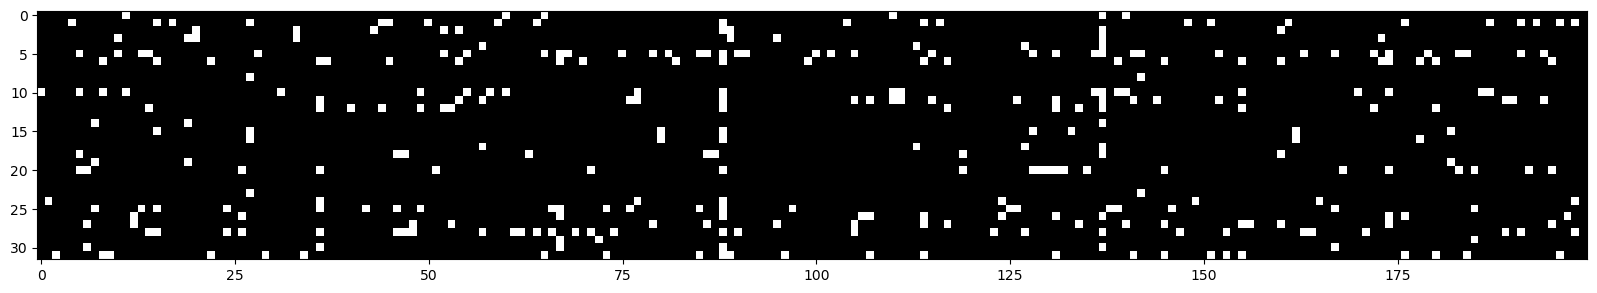

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([463., 241., 185., 165., 147., 111.,  97., 124.,  93., 102., 107.,
         76., 107.,  95., 108., 113.,  89.,  96., 112.,  93., 118.,  85.,
         67., 132., 111., 112., 106., 107.,  85.,  92., 103.,  80.,  93.,
         91.,  81.,  93., 120.,  82., 118., 110., 103., 103., 110., 114.,
        114., 135., 166., 171., 242., 432.]),
 array([-9.99993980e-01, -9.59995644e-01, -9.19997308e-01, -8.79998972e-01,
        -8.40000637e-01, -8.00002301e-01, -7.60003965e-01, -7.20005629e-01,
        -6.80007293e-01, -6.40008957e-01, -6.00010622e-01, -5.60012286e-01,
        -5.20013950e-01, -4.80015614e-01, -4.40017278e-01, -4.00018942e-01,
        -3.60020607e-01, -3.20022271e-01, -2.80023935e-01, -2.40025599e-01,
        -2.00027263e-01, -1.60028927e-01, -1.20030591e-01, -8.00322556e-02,
        -4.00339198e-02, -3.55839729e-05,  3.99627519e-02,  7.99610877e-02,
         1.19959424e-01,  1.59957759e-01,  1.99956095e-01,  2.39954431e-01,
         2.79952767e-01,  3.19951103e-01,  3.59949

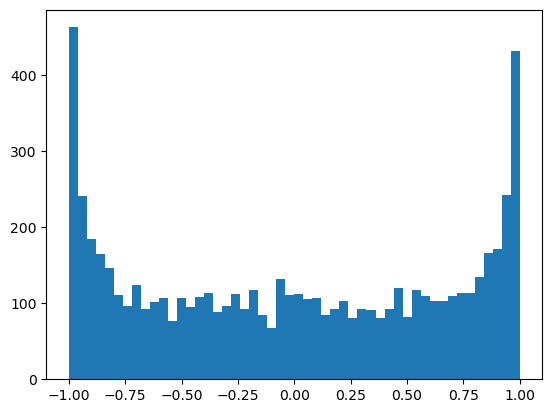

In [9]:
plt.hist(h.view(-1).tolist(), 50)

tensor(0.0061) tensor(1.0032)
tensor(-0.0029) tensor(1.0142)


(array([2.01791253e-05, 4.03582506e-05, 2.01791253e-05, 8.07165012e-05,
        1.21074752e-04, 3.02686880e-04, 4.43940757e-04, 9.68598014e-04,
        1.47307615e-03, 2.64346541e-03, 4.54030319e-03, 8.25326225e-03,
        1.32778644e-02, 2.16723806e-02, 3.52125736e-02, 5.17998146e-02,
        8.02523813e-02, 1.21498513e-01, 1.72592059e-01, 2.33593554e-01,
        3.03413328e-01, 3.64455182e-01, 4.14378338e-01, 4.24588975e-01,
        4.05660956e-01, 3.58623415e-01, 2.89691523e-01, 2.25885129e-01,
        1.63793960e-01, 1.15545671e-01, 7.93241416e-02, 5.36361150e-02,
        3.34771689e-02, 2.19145301e-02, 1.37823426e-02, 7.60753024e-03,
        4.54030319e-03, 3.00668967e-03, 1.59415090e-03, 9.68598014e-04,
        4.84299007e-04, 3.43045130e-04, 1.41253877e-04, 6.05373759e-05,
        4.03582506e-05, 0.00000000e+00, 0.00000000e+00, 4.03582506e-05,
        0.00000000e+00, 2.01791253e-05]),
 array([-5.81515312, -5.56737231, -5.3195915 , -5.07181069, -4.82402988,
        -4.57624907, 

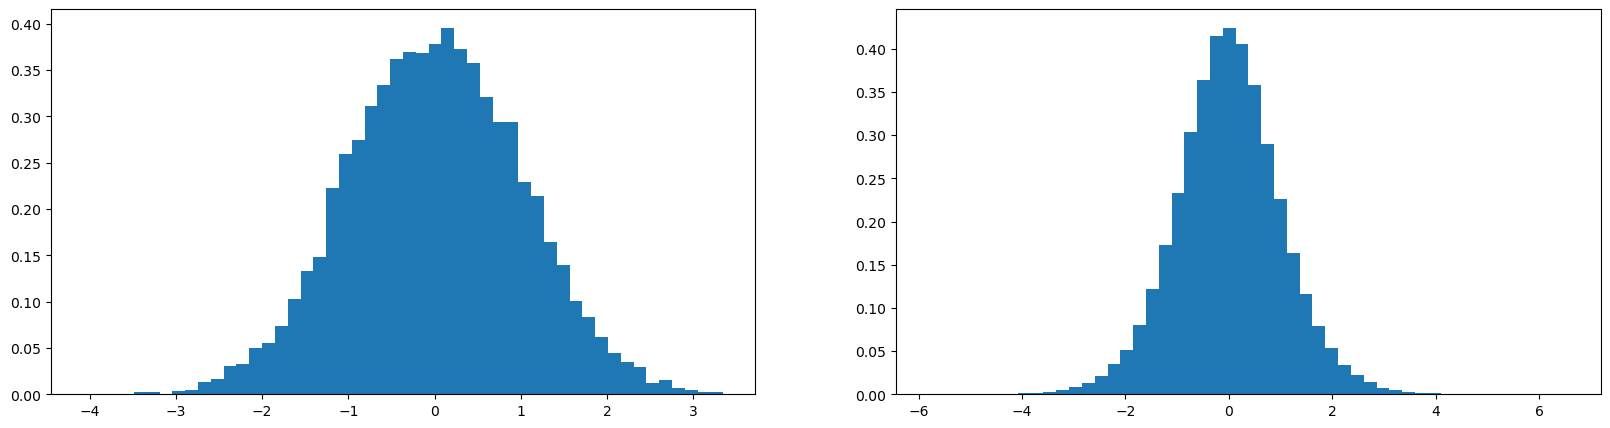

In [10]:
scaling_factor = 10 ** 0.5
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / scaling_factor
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

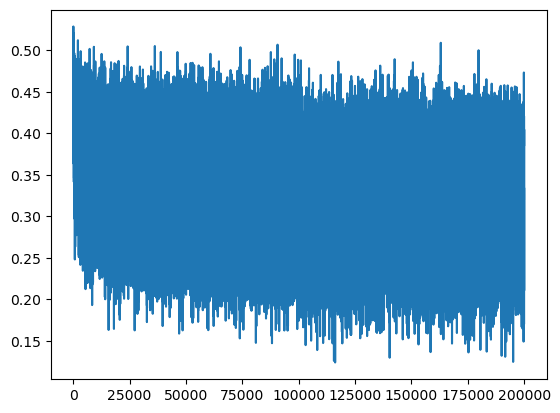

In [11]:
plt.plot(lossi)

In [12]:
# calibrate batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure mean and std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      h = torch.tanh(x @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self):
        return

